In [ ]:
!pip install --target=$nb_path d2l
!pip uninstall --target=$nb_path matplotlib
!pip install --target=$nb_path matplotlib==3.0.2

In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l
from keras.datasets import cifar10
from matplotlib import pyplot as plt
import cv2
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import AvgPool2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

C:\Users\Mira\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Explore Dataset CIFAR10

In [2]:
# Load CIFAR10 Dataset
cifar10_train, cifar10_test = cifar10.load_data()

In [3]:
# Length of train and test dataset
len(cifar10_train[0]), len(cifar10_test[0])

(50000, 10000)

In [4]:
# Shape of images
cifar10_train[0][0].shape

(32, 32, 3)

## Display Images

In [5]:
# Get labels for the images
def get_cifar10_labels(labels):
    #Labels for the CIFAR10 dataset
    text_labels= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    label = []
    for i in labels:
        label.append(text_labels[int(i)])
    return label

In [6]:
#Display images
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols*scale, num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize= figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    # return axes   

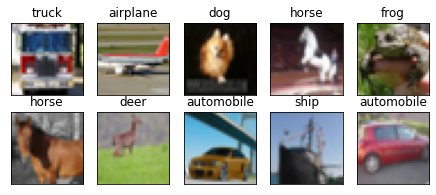

In [13]:
# Display images
import random
start = random.randint(0,49990)
to = start + 10
X = tf.constant(cifar10_train[0][start:to])
y = tf.constant(cifar10_train[1][start:to])
show_images(X, 2, 5, titles=get_cifar10_labels(y))

## Prepare and normalize Dataset for model

In [8]:
def prep_dataset():

  cifar10_train, cifar10_test = cifar10.load_data()
  # convert into float
  trainX = cifar10_train[0].astype('float')
  testX = cifar10_test[0].astype('float')

  # Normalize the data between 0 to 1
  trainX_n = trainX / 255
  testX_n = testX / 255

  #One hot encoding on target variable
  trainY_n = to_categorical(cifar10_train[1])   
  testY_n = to_categorical(cifar10_test[1])

  return trainX_n , trainY_n, testX_n, testY_n

## Define CNN Architecture

In [9]:
def VGG_net():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='lecun_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='lecun_uniform', padding='same'))
  model.add(MaxPool2D(pool_size=2, strides=2))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='lecun_uniform'))
  model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='lecun_uniform'))
  # model.add(Conv2D(128, kernel_size=3, activation='relu', kernel_initializer='lecun_uniform'))
  model.add(MaxPool2D(pool_size=2, strides=2))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, kernel_size=3, activation='relu', kernel_initializer='lecun_uniform'))
  model.add(AvgPool2D(pool_size=2, strides=2))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  # Compile model
  opt = SGD(lr=0.01, momentum=0.6)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics =['accuracy'])

  return model

In [21]:
trainX, trainY, testX, testY = prep_dataset()
model = VGG_net()

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 64)        36928     
                                                      

## Image Agumentation and Fit the model

In [22]:
# Generate Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
with tf.device('/device:GPU:0'):

  # Image agumentation to generate new image data  
  data_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  
  im_train = data_gen.flow(trainX, trainY, batch_size=32)

  # Fit the model  
  history = model.fit_generator(im_train, epochs=50, steps_per_epoch=trainX.shape[0]//32, validation_data=(testX, testY), verbose=1)

<ipython-input-22-86c3a16578c2>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(im_train, epochs=50, steps_per_epoch=trainX.shape[0]//32, validation_data=(testX, testY), verbose=1)


Epoch 1/50
1562/1562 [==============================] - 178s 112ms/step - loss: 1.9533 - accuracy: 0.2722 - val_loss: 1.6088 - val_accuracy: 0.4149
Epoch 2/50
1562/1562 [==============================] - 180s 115ms/step - loss: 1.6044 - accuracy: 0.4071 - val_loss: 1.3621 - val_accuracy: 0.5054
Epoch 3/50
1562/1562 [==============================] - 155s 99ms/step - loss: 1.4601 - accuracy: 0.4636 - val_loss: 1.2465 - val_accuracy: 0.5440
Epoch 4/50
1562/1562 [==============================] - 165s 106ms/step - loss: 1.3532 - accuracy: 0.5095 - val_loss: 1.1980 - val_accuracy: 0.5653
Epoch 5/50
1562/1562 [==============================] - 143s 92ms/step - loss: 1.2626 - accuracy: 0.5482 - val_loss: 1.1162 - val_accuracy: 0.5948
Epoch 6/50
1562/1562 [==============================] - 165s 105ms/step - loss: 1.1898 - accuracy: 0.5753 - val_loss: 1.0138 - val_accuracy: 0.6453
Epoch 7/50
1562/1562 [==============================] - 174s 111ms/step - loss: 1.1241 - accuracy: 0.5979 - val_lo

In [23]:
test_loss, test_acc = model.evaluate(testX, testY, verbose=1)

print('> %.3f' %(test_acc * 100))

313/313 [==============================] - 6s 20ms/step - loss: 0.4901 - accuracy: 0.8321
> 83.210


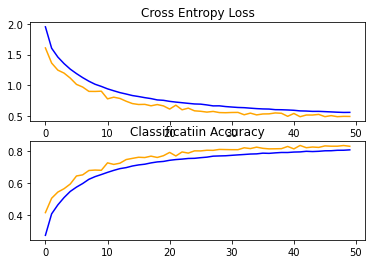

In [24]:
# Summarize and plot
def summarize(history):
  #Plot loss 
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label = 'Train')
  plt.plot(history.history['val_loss'], color='orange', label = 'Test')
  #Plot loss 
  plt.subplot(212)
  plt.title('Classificatiin Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label = 'Train')
  plt.plot(history.history['val_accuracy'], color='orange', label = 'Test')


summarize(history)

## Save Model

In [1]:
# model.save('Classification_model.h5')

## Load Model

In [2]:
from keras.models import load_model

model_fin = load_model('Prediction_Test\\Classification_model.h5')

## Make Prediction

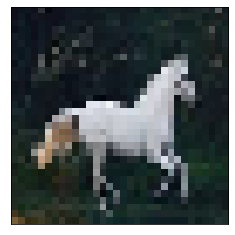

Predicted Class is: 7


In [3]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
 
# read and reshape the image
def prep_image(image):
    image = load_img(image, target_size=(32, 32))
    # Show image
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()
    # Read into an array
    image = img_to_array(image)
    image = image.reshape(1, 32, 32, 3)
    image = image.astype('float32')
    image = image / 255.0
    return image
 
# Read Image
# pred_img = prep_image('Prediction_Test\\sample_image_01.png')
# pred_img = prep_image('Prediction_Test\\sample_image_02.png')
# pred_img = prep_image('Prediction_Test\\sample_image_03.png')
pred_img = prep_image('Prediction_Test\\sample_image_04.png')

# predict the class
pre_class = model_fin.predict(pred_img)
pre_class=np.argmax(pre_class,axis=1)
print("Predicted Class is:", pre_class[0])